
# QGAN: (Q-Net) + GAN (G-Net and D-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Next states given
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # TargetQs/values
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, next_states, actions, targetQs

In [7]:
# Q: Qfunction/Encoder/Classifier
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('qfunction', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
# G: Generator/Decoder: actions can be given actions, generated actions
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        #predictions = tf.sigmoid(logits)

        # return next_states_logits
        return logits

In [9]:
# D: Descriminator/Reward function
def discriminator(next_states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=next_states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # return reward logits
        return logits

In [27]:
def model_loss(states, action_size, hidden_size, actions, targetQs, state_size, next_states):
    # DQN: Q-learning - Bellman equations: loss (targetQ - Q)^2
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_real = tf.one_hot(indices=actions, depth=action_size)
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # GAN: Generate next states
    next_states_logits = generator(actions=actions_logits, state_size=state_size, hidden_size=hidden_size)
    
    # GAN: Discriminate between fake and real
    d_logits_fake = discriminator(next_states=next_states_logits, hidden_size=hidden_size, reuse=False)
    d_logits_real = discriminator(next_states=next_states, hidden_size=hidden_size, reuse=True)

    # GAN: Adverserial training - G-learning
    g_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    g_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.zeros_like(d_logits_real)))
    g_loss = g_loss_real + g_loss_fake
    
    # GAN: Adverserial training - D-learning
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    # Rewards fake/real
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return actions_logits, q_loss, g_loss, d_loss, rewards_fake, rewards_real

In [28]:
def model_opt(q_loss, g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param g_loss: Generator/Decoder loss Tensor for next state prediction
    :param d_loss: Discriminator/Reward loss Tensor for current reward function
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at
    g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return q_opt, g_opt, d_opt

In [29]:
class QGAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.g_loss, self.d_loss, self.rewards_fake, self.rewards_real = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, next_states=self.next_states, actions=self.actions, targetQs=self.targetQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss, g_loss=self.g_loss, d_loss=self.d_loss, 
                                                       learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [30]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [31]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [32]:
train_episodes = 250           # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [33]:
tf.reset_default_graph()

model = QGAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [34]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [35]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list, rewards_fake_list, rewards_real_list = [], [], []
q_loss_list, g_loss_list, d_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    #     # Restore/load the trained model 
    #     #saver.restore(sess, 'checkpoints/model.ckpt')    
    #     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward, rewards_fake_mean, rewards_real_mean = 0, 0, 0
        q_loss, g_loss, d_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Average reward real: {}'.format(rewards_real_mean),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                q_loss_list.append((ep, q_loss))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            #             # Train the model
            #             feed_dict = {model.states: states, model.next_states: next_states}
            #             next_actions_logits, rewards_fake, rewards_real = sess.run([model.actions_logits, 
            #                                                                         model.rewards_fake, model.rewards_real], 
            #                                                                        feed_dict)
            feed_dict = {model.states: states, model.next_states: next_states}
            rewards_fake, rewards_real = sess.run([model.rewards_fake, model.rewards_real], feed_dict)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake and real rewards or rewarded generated/given actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            rewards_real_mean = np.mean(rewards_real.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0) # NOTE: action size

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions, 
                         model.targetQs: targetQs}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 2.0 Average reward fake: 0.4998842477798462 Average reward real: 0.5075330138206482 Training q_loss: 0.3212 Training g_loss: 1.4038 Training d_loss: 1.3737 Explore P: 0.9998
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 19.0 Average reward fake: 0.49134865403175354 Average reward real: 0.5624324679374695 Training q_loss: 0.2945 Training g_loss: 1.5529 Training d_loss: 1.2724 Explore P: 0.9979
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 55.0 Average reward fake: 0.9716011881828308 Average reward real: 0.6531007885932922 Training q_loss: 4.8944 Training g_loss: 1.3943 Training d_loss: 5.8409 Explore P: 0.9925


-------------------------------------------------------------------------------
Episode: 23 Total reward: 43.0 Average reward fake: 0.4948277175426483 Average reward real: 0.5005717277526855 Training q_loss: 13.1641 Training g_loss: 1.4036 Training d_loss: 1.3853 Explore P: 0.9544
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 24 Total reward: 18.0 Average reward fake: 0.5028039813041687 Average reward real: 0.4957582354545593 Training q_loss: 15.2245 Training g_loss: 1.3790 Training d_loss: 1.4162 Explore P: 0.9527
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 25 Total reward: 21.0 Average reward fake: 0.49509888887405396 Average reward real: 0.49297308921813965 Training q_loss: 12.0294 Training g_loss: 1.3864 Training d_loss: 1.4064 Explore P:

-------------------------------------------------------------------------------
Episode: 46 Total reward: 13.0 Average reward fake: 0.508159875869751 Average reward real: 0.5321176052093506 Training q_loss: 55.2027 Training g_loss: 1.4376 Training d_loss: 1.1721 Explore P: 0.9121
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 47 Total reward: 13.0 Average reward fake: 0.13838262856006622 Average reward real: 0.5505499243736267 Training q_loss: 147.2937 Training g_loss: 3.1070 Training d_loss: 0.8054 Explore P: 0.9109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 48 Total reward: 40.0 Average reward fake: 0.4584713280200958 Average reward real: 0.5333510041236877 Training q_loss: 105.7473 Training g_loss: 1.5481 Training d_loss: 1.2886 Explore P:

-------------------------------------------------------------------------------
Episode: 69 Total reward: 53.0 Average reward fake: 0.05489499866962433 Average reward real: 0.9665690660476685 Training q_loss: 14260.4502 Training g_loss: 16.3994 Training d_loss: 0.0886 Explore P: 0.8571
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 70 Total reward: 13.0 Average reward fake: 0.010229058563709259 Average reward real: 0.9710150361061096 Training q_loss: 11281.7373 Training g_loss: 22.8183 Training d_loss: 0.0801 Explore P: 0.8560
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 71 Total reward: 14.0 Average reward fake: 0.0015322673134505749 Average reward real: 0.9711883664131165 Training q_loss: 21133.2324 Training g_loss: 43.6526 Training d_loss: 0

-------------------------------------------------------------------------------
Episode: 92 Total reward: 13.0 Average reward fake: 7.591697226416727e-08 Average reward real: 0.9978029131889343 Training q_loss: 1014514.0625 Training g_loss: 226.3580 Training d_loss: 0.0025 Explore P: 0.8024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 93 Total reward: 27.0 Average reward fake: 0.0002635525306686759 Average reward real: 0.9980485439300537 Training q_loss: 1602372.1250 Training g_loss: 39.6917 Training d_loss: 0.0020 Explore P: 0.8002
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 91.0 Average reward fake: 1.7686289766061236e-06 Average reward real: 0.9985088109970093 Training q_loss: 1998257.6250 Training g_loss: 88.7053 Trainin

-------------------------------------------------------------------------------
Episode: 114 Total reward: 47.0 Average reward fake: 4.325755902597084e-17 Average reward real: 0.9996331930160522 Training q_loss: 46141160.0000 Training g_loss: 271.2857 Training d_loss: 0.0004 Explore P: 0.7350
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 115 Total reward: 22.0 Average reward fake: 3.77075605140281e-26 Average reward real: 0.9995909333229065 Training q_loss: 45443452.0000 Training g_loss: 322.9908 Training d_loss: 0.0004 Explore P: 0.7334
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 116 Total reward: 65.0 Average reward fake: 6.771726605465649e-21 Average reward real: 0.9996201395988464 Training q_loss: 65382380.0000 Training g_loss: 639.0214 T

-------------------------------------------------------------------------------
Episode: 137 Total reward: 32.0 Average reward fake: 0.0 Average reward real: 0.9998820424079895 Training q_loss: 810210368.0000 Training g_loss: 890.3623 Training d_loss: 0.0001 Explore P: 0.6259
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 138 Total reward: 61.0 Average reward fake: 1.086570332483624e-38 Average reward real: 0.9998283386230469 Training q_loss: 1010991616.0000 Training g_loss: 867.9161 Training d_loss: 0.0002 Explore P: 0.6221
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 139 Total reward: 159.0 Average reward fake: 0.0 Average reward real: 0.9999549984931946 Training q_loss: 414266400.0000 Training g_loss: 1330.2716 Training d_loss: 0.0000 Explor

-------------------------------------------------------------------------------
Episode: 160 Total reward: 28.0 Average reward fake: 0.0 Average reward real: 0.999978244304657 Training q_loss: 1293793024.0000 Training g_loss: 487.5707 Training d_loss: 0.0000 Explore P: 0.5240
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 161 Total reward: 199.0 Average reward fake: 0.0 Average reward real: 0.9999040365219116 Training q_loss: 2117980032.0000 Training g_loss: 1037.0925 Training d_loss: 0.0001 Explore P: 0.5139
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 162 Total reward: 199.0 Average reward fake: 0.0 Average reward real: 0.9999901056289673 Training q_loss: 7547549184.0000 Training g_loss: 563.7939 Training d_loss: 0.0000 Explore P: 0.5040
----

-------------------------------------------------------------------------------
Episode: 183 Total reward: 199.0 Average reward fake: 3.703423051282579e-29 Average reward real: 0.9999925494194031 Training q_loss: 1777297024.0000 Training g_loss: 283.8962 Training d_loss: 0.0000 Explore P: 0.3798
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 184 Total reward: 106.0 Average reward fake: 5.520178508762693e-21 Average reward real: 0.9999896287918091 Training q_loss: 2077749632.0000 Training g_loss: 221.9383 Training d_loss: 0.0000 Explore P: 0.3759
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 185 Total reward: 199.0 Average reward fake: 0.0 Average reward real: 0.9999951720237732 Training q_loss: 454120832.0000 Training g_loss: 349.2225 Training d

-------------------------------------------------------------------------------
Episode: 205 Total reward: 199.0 Average reward fake: 1.3336729942636794e-08 Average reward real: 0.9999882578849792 Training q_loss: 555884480.0000 Training g_loss: 83.4807 Training d_loss: 0.0000 Explore P: 0.2654
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 206 Total reward: 142.0 Average reward fake: 8.39257268125948e-08 Average reward real: 0.9999939203262329 Training q_loss: 68612304.0000 Training g_loss: 163.1132 Training d_loss: 0.0000 Explore P: 0.2618
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 207 Total reward: 199.0 Average reward fake: 9.9126897011928e-14 Average reward real: 0.999985933303833 Training q_loss: 159221168.0000 Training g_loss: 123.2678

-------------------------------------------------------------------------------
Episode: 227 Total reward: 157.0 Average reward fake: 4.4372892915589546e-08 Average reward real: 0.9992059469223022 Training q_loss: 38295068.0000 Training g_loss: 78.5826 Training d_loss: 0.0008 Explore P: 0.2147
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 228 Total reward: 199.0 Average reward fake: 1.1056731530345587e-08 Average reward real: 0.9998986124992371 Training q_loss: 35482628.0000 Training g_loss: 102.0535 Training d_loss: 0.0001 Explore P: 0.2107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 229 Total reward: 43.0 Average reward fake: 5.305111372422289e-08 Average reward real: 0.9998883605003357 Training q_loss: 154069184.0000 Training g_loss: 155.8

-------------------------------------------------------------------------------
Episode: 249 Total reward: 27.0 Average reward fake: 8.708069530218021e-13 Average reward real: 0.9857314229011536 Training q_loss: 75489912.0000 Training g_loss: 83.1304 Training d_loss: 0.0223 Explore P: 0.1832
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 250 Total reward: 71.0 Average reward fake: 3.470009914963157e-07 Average reward real: 0.9955670237541199 Training q_loss: 44440400.0000 Training g_loss: 30.1152 Training d_loss: 0.0045 Explore P: 0.1820
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 251 Total reward: 26.0 Average reward fake: 8.992000744001416e-08 Average reward real: 0.9981040954589844 Training q_loss: 55033376.0000 Training g_loss: 43.6609 Tra

-------------------------------------------------------------------------------
Episode: 271 Total reward: 25.0 Average reward fake: 0.0036647305823862553 Average reward real: 0.9954134225845337 Training q_loss: 17621360.0000 Training g_loss: 34.6958 Training d_loss: 0.0073 Explore P: 0.1698
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 272 Total reward: 24.0 Average reward fake: 3.996016564142826e-17 Average reward real: 0.9890965223312378 Training q_loss: 12428833.0000 Training g_loss: 71.4509 Training d_loss: 0.0132 Explore P: 0.1694
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 273 Total reward: 16.0 Average reward fake: 5.682504252035869e-06 Average reward real: 0.9896466135978699 Training q_loss: 11127741.0000 Training g_loss: 22.5463 Tra

-------------------------------------------------------------------------------
Episode: 293 Total reward: 126.0 Average reward fake: 0.00044685162720270455 Average reward real: 0.9986065626144409 Training q_loss: 11662646.0000 Training g_loss: 23.1746 Training d_loss: 0.0014 Explore P: 0.1515
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 294 Total reward: 66.0 Average reward fake: 2.127812370744664e-09 Average reward real: 0.9969106912612915 Training q_loss: 19511192.0000 Training g_loss: 57.4766 Training d_loss: 0.0031 Explore P: 0.1506
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 295 Total reward: 46.0 Average reward fake: 0.00019263674039393663 Average reward real: 0.9977095127105713 Training q_loss: 15490779.0000 Training g_loss: 25.9442 

-------------------------------------------------------------------------------
Episode: 316 Total reward: 21.0 Average reward fake: 0.0015034559182822704 Average reward real: 0.9914332628250122 Training q_loss: 15322932.0000 Training g_loss: 41.5032 Training d_loss: 0.0090 Explore P: 0.1354
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 317 Total reward: 12.0 Average reward fake: 1.232999511557864e-05 Average reward real: 0.9757587909698486 Training q_loss: 2747874.5000 Training g_loss: 21.1499 Training d_loss: 0.0299 Explore P: 0.1352
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 318 Total reward: 78.0 Average reward fake: 2.4459472115268e-05 Average reward real: 0.9745317697525024 Training q_loss: 7405750.5000 Training g_loss: 35.8020 Trainin

-------------------------------------------------------------------------------
Episode: 339 Total reward: 44.0 Average reward fake: 0.06643670797348022 Average reward real: 0.9124671220779419 Training q_loss: 4430587.0000 Training g_loss: 8.1848 Training d_loss: 0.8037 Explore P: 0.1254
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 340 Total reward: 14.0 Average reward fake: 0.007837619632482529 Average reward real: 0.8845745921134949 Training q_loss: 6526018.5000 Training g_loss: 12.2933 Training d_loss: 1.9040 Explore P: 0.1253
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 341 Total reward: 40.0 Average reward fake: 0.004537547938525677 Average reward real: 0.927567720413208 Training q_loss: 1713360.3750 Training g_loss: 23.8436 Training d_l

-------------------------------------------------------------------------------
Episode: 362 Total reward: 55.0 Average reward fake: 0.04413550719618797 Average reward real: 0.9522325396537781 Training q_loss: 3971194.2500 Training g_loss: 15.7143 Training d_loss: 0.4314 Explore P: 0.1142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 363 Total reward: 24.0 Average reward fake: 0.5732073783874512 Average reward real: 0.7347158789634705 Training q_loss: 2384427.2500 Training g_loss: 4.4588 Training d_loss: 0.4964 Explore P: 0.1139
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 364 Total reward: 14.0 Average reward fake: 0.00559578649699688 Average reward real: 0.7430341839790344 Training q_loss: 4492534.0000 Training g_loss: 28.9468 Training d_los

-------------------------------------------------------------------------------
Episode: 385 Total reward: 104.0 Average reward fake: 0.021339435130357742 Average reward real: 0.9944868683815002 Training q_loss: 87743528.0000 Training g_loss: 19.9975 Training d_loss: 0.0144 Explore P: 0.1024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 386 Total reward: 97.0 Average reward fake: 5.799209361612156e-07 Average reward real: 0.9943379759788513 Training q_loss: 4737204.0000 Training g_loss: 103.8635 Training d_loss: 0.0058 Explore P: 0.1015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 387 Total reward: 109.0 Average reward fake: 0.002565414411947131 Average reward real: 0.9806344509124756 Training q_loss: 12487940.0000 Training g_loss: 24.0864 Tra

-------------------------------------------------------------------------------
Episode: 408 Total reward: 102.0 Average reward fake: 0.4990195333957672 Average reward real: 0.4911113679409027 Training q_loss: 1434045.2500 Training g_loss: 1.3726 Training d_loss: 1.4059 Explore P: 0.0827
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 409 Total reward: 16.0 Average reward fake: 0.48789557814598083 Average reward real: 0.509642481803894 Training q_loss: 13685363.0000 Training g_loss: 1.4379 Training d_loss: 1.3594 Explore P: 0.0826
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 410 Total reward: 101.0 Average reward fake: 0.5172800421714783 Average reward real: 0.48706135153770447 Training q_loss: 15899763.0000 Training g_loss: 1.3286 Training d_lo

-------------------------------------------------------------------------------
Episode: 431 Total reward: 106.0 Average reward fake: 0.03783464804291725 Average reward real: 0.9771075248718262 Training q_loss: 5592349.5000 Training g_loss: 13.2530 Training d_loss: 0.0245 Explore P: 0.0674
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 432 Total reward: 104.0 Average reward fake: 0.011029843240976334 Average reward real: 0.9458945989608765 Training q_loss: 19810608.0000 Training g_loss: 17.2736 Training d_loss: 0.0849 Explore P: 0.0668
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 433 Total reward: 105.0 Average reward fake: 0.036009781062603 Average reward real: 0.9396592974662781 Training q_loss: 17560906.0000 Training g_loss: 17.0791 Training

-------------------------------------------------------------------------------
Episode: 454 Total reward: 118.0 Average reward fake: 0.057277318090200424 Average reward real: 0.596539318561554 Training q_loss: 6687773.5000 Training g_loss: 6.6111 Training d_loss: 0.6697 Explore P: 0.0538
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 455 Total reward: 125.0 Average reward fake: 0.5537025332450867 Average reward real: 0.5772531032562256 Training q_loss: 16125509.0000 Training g_loss: 1.6978 Training d_loss: 1.1471 Explore P: 0.0533
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 456 Total reward: 133.0 Average reward fake: 0.48940739035606384 Average reward real: 0.6409474015235901 Training q_loss: 58112652.0000 Training g_loss: 3.0769 Training d_

-------------------------------------------------------------------------------
Episode: 477 Total reward: 170.0 Average reward fake: 0.5096922516822815 Average reward real: 0.49983254075050354 Training q_loss: 2554862.5000 Training g_loss: 1.3706 Training d_loss: 1.4189 Explore P: 0.0412
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 478 Total reward: 186.0 Average reward fake: 0.4850567877292633 Average reward real: 0.5017718076705933 Training q_loss: 7778886.0000 Training g_loss: 1.4249 Training d_loss: 1.3560 Explore P: 0.0406
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 479 Total reward: 174.0 Average reward fake: 0.48275962471961975 Average reward real: 0.5986605286598206 Training q_loss: 1580981.8750 Training g_loss: 2.2575 Training d_lo

-------------------------------------------------------------------------------
Episode: 500 Total reward: 138.0 Average reward fake: 0.48795709013938904 Average reward real: 0.4920763671398163 Training q_loss: 894084.3125 Training g_loss: 1.3961 Training d_loss: 1.3811 Explore P: 0.0300
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 501 Total reward: 165.0 Average reward fake: 0.4993172585964203 Average reward real: 0.5114445090293884 Training q_loss: 3859339.5000 Training g_loss: 1.4145 Training d_loss: 1.3655 Explore P: 0.0296
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 502 Total reward: 160.0 Average reward fake: 0.48834115266799927 Average reward real: 0.48919975757598877 Training q_loss: 1584089.8750 Training g_loss: 1.3893 Training d_lo

-------------------------------------------------------------------------------
Episode: 523 Total reward: 165.0 Average reward fake: 0.5280090570449829 Average reward real: 0.5099518895149231 Training q_loss: 495435.1562 Training g_loss: 1.3734 Training d_loss: 1.4613 Explore P: 0.0246
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 524 Total reward: 67.0 Average reward fake: 0.5390853881835938 Average reward real: 0.5049083232879639 Training q_loss: 486418.5938 Training g_loss: 1.3247 Training d_loss: 1.4667 Explore P: 0.0245
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 525 Total reward: 49.0 Average reward fake: 0.5017188787460327 Average reward real: 0.49213600158691406 Training q_loss: 2244395.2500 Training g_loss: 1.3686 Training d_loss: 1

-------------------------------------------------------------------------------
Episode: 546 Total reward: 88.0 Average reward fake: 0.504126787185669 Average reward real: 0.5093414783477783 Training q_loss: 1474628.5000 Training g_loss: 1.3970 Training d_loss: 1.3764 Explore P: 0.0223
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 547 Total reward: 30.0 Average reward fake: 0.5051256418228149 Average reward real: 0.5093080997467041 Training q_loss: 872144.1875 Training g_loss: 1.3951 Training d_loss: 1.3788 Explore P: 0.0223
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 548 Total reward: 121.0 Average reward fake: 0.47561195492744446 Average reward real: 0.48697322607040405 Training q_loss: 526682.2500 Training g_loss: 1.4113 Training d_loss: 1

-------------------------------------------------------------------------------
Episode: 569 Total reward: 105.0 Average reward fake: 0.5058923959732056 Average reward real: 0.504199743270874 Training q_loss: 749088.1875 Training g_loss: 1.3832 Training d_loss: 1.3904 Explore P: 0.0204
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 570 Total reward: 39.0 Average reward fake: 0.4966590106487274 Average reward real: 0.49311164021492004 Training q_loss: 287306.6250 Training g_loss: 1.3794 Training d_loss: 1.3939 Explore P: 0.0204
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 571 Total reward: 33.0 Average reward fake: 0.49954551458358765 Average reward real: 0.49773308634757996 Training q_loss: 224384.9844 Training g_loss: 1.3827 Training d_loss: 1

-------------------------------------------------------------------------------
Episode: 592 Total reward: 28.0 Average reward fake: 0.5044518113136292 Average reward real: 0.5059131383895874 Training q_loss: 337758.2812 Training g_loss: 1.3894 Training d_loss: 1.3838 Explore P: 0.0189
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 593 Total reward: 132.0 Average reward fake: 0.4964086413383484 Average reward real: 0.4993380606174469 Training q_loss: 131927.8594 Training g_loss: 1.3924 Training d_loss: 1.3811 Explore P: 0.0188
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 594 Total reward: 61.0 Average reward fake: 0.5073498487472534 Average reward real: 0.5075975656509399 Training q_loss: 503458.6250 Training g_loss: 1.3871 Training d_loss: 1.3

-------------------------------------------------------------------------------
Episode: 615 Total reward: 40.0 Average reward fake: 0.496359646320343 Average reward real: 0.4949693977832794 Training q_loss: 326488.7812 Training g_loss: 1.3837 Training d_loss: 1.3895 Explore P: 0.0169
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 616 Total reward: 199.0 Average reward fake: 0.50090491771698 Average reward real: 0.500917911529541 Training q_loss: 111401.1875 Training g_loss: 1.3863 Training d_loss: 1.3866 Explore P: 0.0168
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 617 Total reward: 65.0 Average reward fake: 0.4903015196323395 Average reward real: 0.4893154203891754 Training q_loss: 161813.0625 Training g_loss: 1.3847 Training d_loss: 1.3888 

-------------------------------------------------------------------------------
Episode: 638 Total reward: 103.0 Average reward fake: 0.5060489773750305 Average reward real: 0.5070577263832092 Training q_loss: 192419.7656 Training g_loss: 1.3885 Training d_loss: 1.3847 Explore P: 0.0154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 639 Total reward: 110.0 Average reward fake: 0.5032376050949097 Average reward real: 0.5019320845603943 Training q_loss: 345294.0938 Training g_loss: 1.3838 Training d_loss: 1.3889 Explore P: 0.0153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 640 Total reward: 147.0 Average reward fake: 0.49043571949005127 Average reward real: 0.4912947714328766 Training q_loss: 129722.2188 Training g_loss: 1.3884 Training d_loss: 

-------------------------------------------------------------------------------
Episode: 661 Total reward: 99.0 Average reward fake: 0.49984118342399597 Average reward real: 0.49894219636917114 Training q_loss: 74555.1406 Training g_loss: 1.3845 Training d_loss: 1.3883 Explore P: 0.0140
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 662 Total reward: 166.0 Average reward fake: 0.5028592944145203 Average reward real: 0.5024797320365906 Training q_loss: 226623.6562 Training g_loss: 1.3858 Training d_loss: 1.3874 Explore P: 0.0140
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 663 Total reward: 102.0 Average reward fake: 0.4971381723880768 Average reward real: 0.4972530007362366 Training q_loss: 198135.5781 Training g_loss: 1.3866 Training d_loss: 1

-------------------------------------------------------------------------------
Episode: 684 Total reward: 167.0 Average reward fake: 0.5002313256263733 Average reward real: 0.49975907802581787 Training q_loss: 77678.2031 Training g_loss: 1.3854 Training d_loss: 1.3873 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 685 Total reward: 163.0 Average reward fake: 0.5001253485679626 Average reward real: 0.49950337409973145 Training q_loss: 44275.1602 Training g_loss: 1.3850 Training d_loss: 1.3876 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 686 Total reward: 170.0 Average reward fake: 0.500560998916626 Average reward real: 0.49989432096481323 Training q_loss: 74199.0234 Training g_loss: 1.3850 Training d_loss: 1.

-------------------------------------------------------------------------------
Episode: 707 Total reward: 89.0 Average reward fake: 0.49851128458976746 Average reward real: 0.4984382390975952 Training q_loss: 32207.5547 Training g_loss: 1.3862 Training d_loss: 1.3865 Explore P: 0.0123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 708 Total reward: 168.0 Average reward fake: 0.4992431700229645 Average reward real: 0.49962738156318665 Training q_loss: 33387.9531 Training g_loss: 1.3871 Training d_loss: 1.3856 Explore P: 0.0122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 709 Total reward: 167.0 Average reward fake: 0.5012364387512207 Average reward real: 0.5018364191055298 Training q_loss: 66958.2031 Training g_loss: 1.3875 Training d_loss: 1.3

-------------------------------------------------------------------------------
Episode: 730 Total reward: 199.0 Average reward fake: 0.5006176829338074 Average reward real: 0.4999759793281555 Training q_loss: 241905.2344 Training g_loss: 1.3850 Training d_loss: 1.3876 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 731 Total reward: 183.0 Average reward fake: 0.4991719722747803 Average reward real: 0.49898380041122437 Training q_loss: 182166.8125 Training g_loss: 1.3859 Training d_loss: 1.3867 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 732 Total reward: 199.0 Average reward fake: 0.5004626512527466 Average reward real: 0.5008745789527893 Training q_loss: 219424.4844 Training g_loss: 1.3871 Training d_loss: 

-------------------------------------------------------------------------------
Episode: 753 Total reward: 199.0 Average reward fake: 0.4583955705165863 Average reward real: 0.49279844760894775 Training q_loss: 120078.6797 Training g_loss: 1.4614 Training d_loss: 1.3753 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 754 Total reward: 199.0 Average reward fake: 0.5045171976089478 Average reward real: 0.5017812848091125 Training q_loss: 40104.6289 Training g_loss: 1.3809 Training d_loss: 1.3940 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 755 Total reward: 199.0 Average reward fake: 0.4999948740005493 Average reward real: 0.5007115006446838 Training q_loss: 737090.8750 Training g_loss: 1.3878 Training d_loss: 1

-------------------------------------------------------------------------------
Episode: 776 Total reward: 199.0 Average reward fake: 0.49923545122146606 Average reward real: 0.49988579750061035 Training q_loss: 287516.8125 Training g_loss: 1.3876 Training d_loss: 1.3852 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 777 Total reward: 199.0 Average reward fake: 0.4963816702365875 Average reward real: 0.49646151065826416 Training q_loss: 161859.9844 Training g_loss: 1.3865 Training d_loss: 1.3862 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 778 Total reward: 199.0 Average reward fake: 0.5002644062042236 Average reward real: 0.5009509325027466 Training q_loss: 234503.0469 Training g_loss: 1.3877 Training d_loss

-------------------------------------------------------------------------------
Episode: 799 Total reward: 199.0 Average reward fake: 0.5000492334365845 Average reward real: 0.49997442960739136 Training q_loss: 392416.0312 Training g_loss: 1.3861 Training d_loss: 1.3864 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 800 Total reward: 199.0 Average reward fake: 0.49945303797721863 Average reward real: 0.49926939606666565 Training q_loss: 347282.2500 Training g_loss: 1.3859 Training d_loss: 1.3867 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 801 Total reward: 199.0 Average reward fake: 0.5313202738761902 Average reward real: 0.5240393280982971 Training q_loss: 116243.7422 Training g_loss: 1.3749 Training d_loss

-------------------------------------------------------------------------------
Episode: 822 Total reward: 199.0 Average reward fake: 0.499907523393631 Average reward real: 0.4994433522224426 Training q_loss: 155060.9844 Training g_loss: 1.3854 Training d_loss: 1.3872 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 823 Total reward: 199.0 Average reward fake: 0.499414324760437 Average reward real: 0.4990738332271576 Training q_loss: 65766.9062 Training g_loss: 1.3856 Training d_loss: 1.3870 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 824 Total reward: 199.0 Average reward fake: 0.4998340606689453 Average reward real: 0.5015330910682678 Training q_loss: 488827.6250 Training g_loss: 1.3897 Training d_loss: 1.38

-------------------------------------------------------------------------------
Episode: 845 Total reward: 199.0 Average reward fake: 0.4999781548976898 Average reward real: 0.49982139468193054 Training q_loss: 32330.7051 Training g_loss: 1.3860 Training d_loss: 1.3866 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 846 Total reward: 199.0 Average reward fake: 0.500282883644104 Average reward real: 0.4997144341468811 Training q_loss: 44477.8750 Training g_loss: 1.3852 Training d_loss: 1.3875 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 847 Total reward: 199.0 Average reward fake: 0.5002259612083435 Average reward real: 0.4998304843902588 Training q_loss: 19954.3379 Training g_loss: 1.3855 Training d_loss: 1.38

-------------------------------------------------------------------------------
Episode: 868 Total reward: 199.0 Average reward fake: 0.500087559223175 Average reward real: 0.49972641468048096 Training q_loss: 298708.1250 Training g_loss: 1.3856 Training d_loss: 1.3871 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 869 Total reward: 199.0 Average reward fake: 0.5003721117973328 Average reward real: 0.5004702806472778 Training q_loss: 149973.5156 Training g_loss: 1.3865 Training d_loss: 1.3861 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 870 Total reward: 199.0 Average reward fake: 0.5000576972961426 Average reward real: 0.5003180503845215 Training q_loss: 17549.1953 Training g_loss: 1.3868 Training d_loss: 1.

-------------------------------------------------------------------------------
Episode: 891 Total reward: 199.0 Average reward fake: 0.5012339949607849 Average reward real: 0.49981167912483215 Training q_loss: 53950.7891 Training g_loss: 1.3835 Training d_loss: 1.3898 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 892 Total reward: 199.0 Average reward fake: 0.49969854950904846 Average reward real: 0.49981075525283813 Training q_loss: 30386.3145 Training g_loss: 1.3866 Training d_loss: 1.3864 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 893 Total reward: 199.0 Average reward fake: 0.5005847811698914 Average reward real: 0.5010449886322021 Training q_loss: 369302.4688 Training g_loss: 1.3875 Training d_loss: 

-------------------------------------------------------------------------------
Episode: 914 Total reward: 105.0 Average reward fake: 0.4992690980434418 Average reward real: 0.49811118841171265 Training q_loss: 17855.6602 Training g_loss: 1.3840 Training d_loss: 1.3886 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 915 Total reward: 131.0 Average reward fake: 0.5014586448669434 Average reward real: 0.5012326240539551 Training q_loss: 42457.0781 Training g_loss: 1.3859 Training d_loss: 1.3868 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 916 Total reward: 199.0 Average reward fake: 0.5037299990653992 Average reward real: 0.5021623373031616 Training q_loss: 46192.1641 Training g_loss: 1.3833 Training d_loss: 1.3

-------------------------------------------------------------------------------
Episode: 937 Total reward: 199.0 Average reward fake: 0.5029472708702087 Average reward real: 0.4986594319343567 Training q_loss: 6612.9907 Training g_loss: 1.3783 Training d_loss: 1.3970 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 938 Total reward: 96.0 Average reward fake: 0.502524197101593 Average reward real: 0.5014038681983948 Training q_loss: 40497.3867 Training g_loss: 1.3841 Training d_loss: 1.3886 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 939 Total reward: 92.0 Average reward fake: 0.5002466440200806 Average reward real: 0.5011559128761292 Training q_loss: 25445.3398 Training g_loss: 1.3881 Training d_loss: 1.3845 E

-------------------------------------------------------------------------------
Episode: 960 Total reward: 199.0 Average reward fake: 0.5043994188308716 Average reward real: 0.49977371096611023 Training q_loss: 13333.9414 Training g_loss: 1.3772 Training d_loss: 1.3964 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 961 Total reward: 61.0 Average reward fake: 0.4922729432582855 Average reward real: 0.5077211260795593 Training q_loss: 104068.5938 Training g_loss: 1.4183 Training d_loss: 1.3610 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 962 Total reward: 128.0 Average reward fake: 0.4976023733615875 Average reward real: 0.5011687278747559 Training q_loss: 14426.2227 Training g_loss: 1.3935 Training d_loss: 1.3

-------------------------------------------------------------------------------
Episode: 983 Total reward: 199.0 Average reward fake: 0.5009925961494446 Average reward real: 0.4987300932407379 Training q_loss: 47720.3945 Training g_loss: 1.3820 Training d_loss: 1.3912 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 984 Total reward: 185.0 Average reward fake: 0.5002270340919495 Average reward real: 0.49680668115615845 Training q_loss: 14594.5039 Training g_loss: 1.3795 Training d_loss: 1.3929 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 985 Total reward: 155.0 Average reward fake: 0.5005791783332825 Average reward real: 0.4993370771408081 Training q_loss: 3756.5791 Training g_loss: 1.3839 Training d_loss: 1.38

-------------------------------------------------------------------------------
Episode: 1006 Total reward: 136.0 Average reward fake: 0.5003669857978821 Average reward real: 0.4968632459640503 Training q_loss: 21144.0566 Training g_loss: 1.3794 Training d_loss: 1.3935 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1007 Total reward: 199.0 Average reward fake: 0.5048120021820068 Average reward real: 0.49990272521972656 Training q_loss: 19814.3320 Training g_loss: 1.3765 Training d_loss: 1.3969 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1008 Total reward: 125.0 Average reward fake: 0.5003897547721863 Average reward real: 0.4996895492076874 Training q_loss: 6323.5269 Training g_loss: 1.3850 Training d_loss: 1

-------------------------------------------------------------------------------
Episode: 1029 Total reward: 199.0 Average reward fake: 0.5023046135902405 Average reward real: 0.4976651668548584 Training q_loss: 5075.7095 Training g_loss: 1.3769 Training d_loss: 1.3968 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1030 Total reward: 199.0 Average reward fake: 0.5035831928253174 Average reward real: 0.500266432762146 Training q_loss: 29981.0703 Training g_loss: 1.3800 Training d_loss: 1.3933 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1031 Total reward: 199.0 Average reward fake: 0.500313401222229 Average reward real: 0.5007638335227966 Training q_loss: 24902.9316 Training g_loss: 1.3872 Training d_loss: 1.38

-------------------------------------------------------------------------------
Episode: 1052 Total reward: 146.0 Average reward fake: 0.4884152114391327 Average reward real: 0.4815268814563751 Training q_loss: 10359.3242 Training g_loss: 1.3739 Training d_loss: 1.4002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1053 Total reward: 199.0 Average reward fake: 0.5142476558685303 Average reward real: 0.5098105072975159 Training q_loss: 12875.8252 Training g_loss: 1.3783 Training d_loss: 1.3964 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1054 Total reward: 140.0 Average reward fake: 0.48029494285583496 Average reward real: 0.4766199588775635 Training q_loss: 11845.8398 Training g_loss: 1.3810 Training d_loss: 

-------------------------------------------------------------------------------
Episode: 1075 Total reward: 126.0 Average reward fake: 0.4937676191329956 Average reward real: 0.4918462038040161 Training q_loss: 10446.0898 Training g_loss: 1.3829 Training d_loss: 1.3923 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1076 Total reward: 142.0 Average reward fake: 0.5054334998130798 Average reward real: 0.500193178653717 Training q_loss: 23693.5645 Training g_loss: 1.3764 Training d_loss: 1.3982 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1077 Total reward: 120.0 Average reward fake: 0.5036622881889343 Average reward real: 0.5049759149551392 Training q_loss: 3863.6621 Training g_loss: 1.3891 Training d_loss: 1.3

-------------------------------------------------------------------------------
Episode: 1098 Total reward: 39.0 Average reward fake: 0.4992591142654419 Average reward real: 0.4955000579357147 Training q_loss: 119749.1797 Training g_loss: 1.3790 Training d_loss: 1.3939 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1099 Total reward: 199.0 Average reward fake: 0.499582976102829 Average reward real: 0.500318706035614 Training q_loss: 16948.5098 Training g_loss: 1.3878 Training d_loss: 1.3849 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1100 Total reward: 199.0 Average reward fake: 0.5024738311767578 Average reward real: 0.5008338689804077 Training q_loss: 7082.9863 Training g_loss: 1.3831 Training d_loss: 1.39

-------------------------------------------------------------------------------
Episode: 1121 Total reward: 199.0 Average reward fake: 0.5069724917411804 Average reward real: 0.5034275650978088 Training q_loss: 3284.2175 Training g_loss: 1.3795 Training d_loss: 1.3944 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1122 Total reward: 123.0 Average reward fake: 0.49870550632476807 Average reward real: 0.49728307127952576 Training q_loss: 2509.4651 Training g_loss: 1.3835 Training d_loss: 1.3896 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1123 Total reward: 163.0 Average reward fake: 0.49410057067871094 Average reward real: 0.4918767511844635 Training q_loss: 1637.8834 Training g_loss: 1.3822 Training d_loss: 1

-------------------------------------------------------------------------------
Episode: 1145 Total reward: 10.0 Average reward fake: 0.5027214288711548 Average reward real: 0.5020207166671753 Training q_loss: 2531431424.0000 Training g_loss: 1.3849 Training d_loss: 1.3878 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1146 Total reward: 11.0 Average reward fake: 0.5017855167388916 Average reward real: 0.5020277500152588 Training q_loss: 2948708096.0000 Training g_loss: 1.3869 Training d_loss: 1.3827 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1147 Total reward: 9.0 Average reward fake: 0.5020493865013123 Average reward real: 0.5037688612937927 Training q_loss: 6693252096.0000 Training g_loss: 1.3901 Trainin

-------------------------------------------------------------------------------
Episode: 1167 Total reward: 10.0 Average reward fake: 0.3435763418674469 Average reward real: 0.5067379474639893 Training q_loss: 61492097024.0000 Training g_loss: 1.8615 Training d_loss: 1.0931 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1168 Total reward: 9.0 Average reward fake: 0.3519609868526459 Average reward real: 0.5624186992645264 Training q_loss: 125380739072.0000 Training g_loss: 1.9605 Training d_loss: 1.4550 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1169 Total reward: 12.0 Average reward fake: 0.40846383571624756 Average reward real: 0.5464887022972107 Training q_loss: 69120131072.0000 Training g_loss: 1.7319 Tr

-------------------------------------------------------------------------------
Episode: 1189 Total reward: 9.0 Average reward fake: 0.5136628150939941 Average reward real: 0.5075322389602661 Training q_loss: 270216691712.0000 Training g_loss: 1.3749 Training d_loss: 1.4005 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1190 Total reward: 10.0 Average reward fake: 0.507901132106781 Average reward real: 0.5067121982574463 Training q_loss: 537424986112.0000 Training g_loss: 1.3843 Training d_loss: 1.3895 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1191 Total reward: 11.0 Average reward fake: 0.5058207511901855 Average reward real: 0.49380889534950256 Training q_loss: 748102746112.0000 Training g_loss: 1.3630 T

-------------------------------------------------------------------------------
Episode: 1212 Total reward: 10.0 Average reward fake: 0.5173577666282654 Average reward real: 0.49927079677581787 Training q_loss: 5112572936192.0000 Training g_loss: 1.3547 Training d_loss: 1.4387 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1213 Total reward: 7.0 Average reward fake: 0.26233845949172974 Average reward real: 0.4796219766139984 Training q_loss: 4098506883072.0000 Training g_loss: 2.0805 Training d_loss: 0.7448 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1214 Total reward: 9.0 Average reward fake: 0.11244309693574905 Average reward real: 0.649935781955719 Training q_loss: 1950914052096.0000 Training g_loss: 4.20

-------------------------------------------------------------------------------
Episode: 1235 Total reward: 12.0 Average reward fake: 0.5131152868270874 Average reward real: 0.5018413662910461 Training q_loss: 6112746668032.0000 Training g_loss: 1.3652 Training d_loss: 1.4110 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1236 Total reward: 8.0 Average reward fake: 0.5108890533447266 Average reward real: 0.5008744597434998 Training q_loss: 507274559488.0000 Training g_loss: 1.3678 Training d_loss: 1.4105 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1237 Total reward: 7.0 Average reward fake: 0.5143107771873474 Average reward real: 0.5022830367088318 Training q_loss: 5528675680256.0000 Training g_loss: 1.3633 

-------------------------------------------------------------------------------
Episode: 1257 Total reward: 10.0 Average reward fake: 0.5009955167770386 Average reward real: 0.5011178851127625 Training q_loss: 18727525416960.0000 Training g_loss: 1.3868 Training d_loss: 1.3896 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1258 Total reward: 8.0 Average reward fake: 0.5054680109024048 Average reward real: 0.49942547082901 Training q_loss: 147391594496.0000 Training g_loss: 1.3749 Training d_loss: 1.3983 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1259 Total reward: 8.0 Average reward fake: 0.5078046917915344 Average reward real: 0.49853751063346863 Training q_loss: 153950633984.0000 Training g_loss: 1.3682 T

-------------------------------------------------------------------------------
Episode: 1280 Total reward: 11.0 Average reward fake: 0.5002108812332153 Average reward real: 0.49731576442718506 Training q_loss: 2709003960320.0000 Training g_loss: 1.3807 Training d_loss: 1.3929 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1281 Total reward: 9.0 Average reward fake: 0.4993093013763428 Average reward real: 0.49707457423210144 Training q_loss: 3886782087168.0000 Training g_loss: 1.3820 Training d_loss: 1.3916 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1282 Total reward: 9.0 Average reward fake: 0.5043447613716125 Average reward real: 0.49726855754852295 Training q_loss: 10540385566720.0000 Training g_loss: 1.

-------------------------------------------------------------------------------
Episode: 1302 Total reward: 10.0 Average reward fake: 0.49672240018844604 Average reward real: 0.4930258095264435 Training q_loss: 7960487002112.0000 Training g_loss: 1.3791 Training d_loss: 1.3939 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1303 Total reward: 11.0 Average reward fake: 0.4963088929653168 Average reward real: 0.49625837802886963 Training q_loss: 3140539383808.0000 Training g_loss: 1.3863 Training d_loss: 1.3869 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1304 Total reward: 10.0 Average reward fake: 0.4987751841545105 Average reward real: 0.4986020028591156 Training q_loss: 3856502095872.0000 Training g_loss: 1.

-------------------------------------------------------------------------------
Episode: 1324 Total reward: 9.0 Average reward fake: 0.5060471892356873 Average reward real: 0.5056149959564209 Training q_loss: 6873055232.0000 Training g_loss: 1.3856 Training d_loss: 1.3891 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1325 Total reward: 11.0 Average reward fake: 0.5125086307525635 Average reward real: 0.5071840882301331 Training q_loss: 3642235289600.0000 Training g_loss: 1.3762 Training d_loss: 1.4018 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1326 Total reward: 11.0 Average reward fake: 0.5057689547538757 Average reward real: 0.49952301383018494 Training q_loss: 7728834048.0000 Training g_loss: 1.3741 Tra

-------------------------------------------------------------------------------
Episode: 1347 Total reward: 8.0 Average reward fake: 0.5004811882972717 Average reward real: 0.5070570111274719 Training q_loss: 7948964352.0000 Training g_loss: 1.3996 Training d_loss: 1.3742 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1348 Total reward: 10.0 Average reward fake: 0.5021513104438782 Average reward real: 0.5061898231506348 Training q_loss: 4394367582208.0000 Training g_loss: 1.3947 Training d_loss: 1.3814 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1349 Total reward: 11.0 Average reward fake: 0.5138704776763916 Average reward real: 0.4970698654651642 Training q_loss: 207825043456.0000 Training g_loss: 1.3534 Tr

-------------------------------------------------------------------------------
Episode: 1369 Total reward: 7.0 Average reward fake: 0.5065559148788452 Average reward real: 0.5007533431053162 Training q_loss: 4420999839744.0000 Training g_loss: 1.3749 Training d_loss: 1.3984 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1370 Total reward: 8.0 Average reward fake: 0.5052722096443176 Average reward real: 0.5024281740188599 Training q_loss: 1428366163968.0000 Training g_loss: 1.3807 Training d_loss: 1.3924 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1371 Total reward: 10.0 Average reward fake: 0.5044336915016174 Average reward real: 0.5035097599029541 Training q_loss: 10467105792.0000 Training g_loss: 1.3845 T

-------------------------------------------------------------------------------
Episode: 1392 Total reward: 8.0 Average reward fake: 0.4960973858833313 Average reward real: 0.49605298042297363 Training q_loss: 417289306112.0000 Training g_loss: 1.3863 Training d_loss: 1.3867 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1393 Total reward: 9.0 Average reward fake: 0.4982929229736328 Average reward real: 0.498454749584198 Training q_loss: 451100377088.0000 Training g_loss: 1.3867 Training d_loss: 1.3863 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1394 Total reward: 11.0 Average reward fake: 0.5020446181297302 Average reward real: 0.5012860298156738 Training q_loss: 1253141512192.0000 Training g_loss: 1.3849 T

-------------------------------------------------------------------------------
Episode: 1414 Total reward: 11.0 Average reward fake: 0.49322813749313354 Average reward real: 0.4903009831905365 Training q_loss: 15942746112.0000 Training g_loss: 1.3808 Training d_loss: 1.3938 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1415 Total reward: 11.0 Average reward fake: 0.49431389570236206 Average reward real: 0.49191054701805115 Training q_loss: 14474516480.0000 Training g_loss: 1.3818 Training d_loss: 1.3911 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1416 Total reward: 11.0 Average reward fake: 0.495688796043396 Average reward real: 0.49576157331466675 Training q_loss: 689970085888.0000 Training g_loss: 1.3865

-------------------------------------------------------------------------------
Episode: 1436 Total reward: 9.0 Average reward fake: 0.5059186816215515 Average reward real: 0.503719687461853 Training q_loss: 770821718016.0000 Training g_loss: 1.3820 Training d_loss: 1.3910 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1437 Total reward: 7.0 Average reward fake: 0.5037620663642883 Average reward real: 0.501323938369751 Training q_loss: 1107865763840.0000 Training g_loss: 1.3815 Training d_loss: 1.3914 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1438 Total reward: 9.0 Average reward fake: 0.5014052391052246 Average reward real: 0.5000621676445007 Training q_loss: 812410667008.0000 Training g_loss: 1.3836 Trai

-------------------------------------------------------------------------------
Episode: 1458 Total reward: 10.0 Average reward fake: 0.5026779770851135 Average reward real: 0.4978717863559723 Training q_loss: 2129791287296.0000 Training g_loss: 1.3768 Training d_loss: 1.3966 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1459 Total reward: 9.0 Average reward fake: 0.5005451440811157 Average reward real: 0.4959169626235962 Training q_loss: 4564186038272.0000 Training g_loss: 1.3771 Training d_loss: 1.3959 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1460 Total reward: 11.0 Average reward fake: 0.4986366927623749 Average reward real: 0.4968605935573578 Training q_loss: 6837075456.0000 Training g_loss: 1.3828 T

-------------------------------------------------------------------------------
Episode: 1480 Total reward: 11.0 Average reward fake: 0.49199196696281433 Average reward real: 0.4846927225589752 Training q_loss: 1273687703552.0000 Training g_loss: 1.3724 Training d_loss: 1.4017 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1481 Total reward: 10.0 Average reward fake: 0.48530814051628113 Average reward real: 0.4875572621822357 Training q_loss: 1071464120320.0000 Training g_loss: 1.3917 Training d_loss: 1.3834 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1482 Total reward: 10.0 Average reward fake: 0.48587530851364136 Average reward real: 0.49685898423194885 Training q_loss: 1817476202496.0000 Training g_loss: 

-------------------------------------------------------------------------------
Episode: 1502 Total reward: 11.0 Average reward fake: 0.502109706401825 Average reward real: 0.5012806057929993 Training q_loss: 411333099520.0000 Training g_loss: 1.3849 Training d_loss: 1.3892 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1503 Total reward: 9.0 Average reward fake: 0.504226565361023 Average reward real: 0.49929070472717285 Training q_loss: 4800454144.0000 Training g_loss: 1.3767 Training d_loss: 1.3977 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1504 Total reward: 11.0 Average reward fake: 0.5063320398330688 Average reward real: 0.4958087205886841 Training q_loss: 550652542976.0000 Training g_loss: 1.3655 Trai

-------------------------------------------------------------------------------
Episode: 1525 Total reward: 9.0 Average reward fake: 0.5072460174560547 Average reward real: 0.5025439262390137 Training q_loss: 1030533349376.0000 Training g_loss: 1.3771 Training d_loss: 1.3962 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1526 Total reward: 7.0 Average reward fake: 0.5061143636703491 Average reward real: 0.5036343932151794 Training q_loss: 1363679903744.0000 Training g_loss: 1.3815 Training d_loss: 1.3914 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1527 Total reward: 9.0 Average reward fake: 0.5037133097648621 Average reward real: 0.5044823288917542 Training q_loss: 429088571392.0000 Training g_loss: 1.3879 T

-------------------------------------------------------------------------------
Episode: 1548 Total reward: 11.0 Average reward fake: 0.49967706203460693 Average reward real: 0.5009410381317139 Training q_loss: 1522846269440.0000 Training g_loss: 1.3888 Training d_loss: 1.3840 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1549 Total reward: 8.0 Average reward fake: 0.49887603521347046 Average reward real: 0.501197338104248 Training q_loss: 2709216559104.0000 Training g_loss: 1.3910 Training d_loss: 1.3818 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1550 Total reward: 12.0 Average reward fake: 0.4980173408985138 Average reward real: 0.501218855381012 Training q_loss: 736174866432.0000 Training g_loss: 1.3928

-------------------------------------------------------------------------------
Episode: 1570 Total reward: 11.0 Average reward fake: 0.49937865138053894 Average reward real: 0.499045729637146 Training q_loss: 1913069502464.0000 Training g_loss: 1.3857 Training d_loss: 1.3873 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1571 Total reward: 13.0 Average reward fake: 0.5028906464576721 Average reward real: 0.49975621700286865 Training q_loss: 54519226368.0000 Training g_loss: 1.3801 Training d_loss: 1.3929 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1572 Total reward: 10.0 Average reward fake: 0.5037901401519775 Average reward real: 0.5001582503318787 Training q_loss: 1755467218944.0000 Training g_loss: 1.379

-------------------------------------------------------------------------------
Episode: 1592 Total reward: 18.0 Average reward fake: 0.4943082928657532 Average reward real: 0.4909253716468811 Training q_loss: 335032549376.0000 Training g_loss: 1.3798 Training d_loss: 1.3931 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1593 Total reward: 29.0 Average reward fake: 0.49763593077659607 Average reward real: 0.498208612203598 Training q_loss: 351707824128.0000 Training g_loss: 1.3875 Training d_loss: 1.3853 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1594 Total reward: 28.0 Average reward fake: 0.4987460970878601 Average reward real: 0.49898743629455566 Training q_loss: 282412843008.0000 Training g_loss: 1.3868

-------------------------------------------------------------------------------
Episode: 1614 Total reward: 39.0 Average reward fake: 0.5020297169685364 Average reward real: 0.5015369653701782 Training q_loss: 452505731072.0000 Training g_loss: 1.3853 Training d_loss: 1.3873 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1615 Total reward: 39.0 Average reward fake: 0.5007469654083252 Average reward real: 0.4998460114002228 Training q_loss: 198096912384.0000 Training g_loss: 1.3845 Training d_loss: 1.3889 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1616 Total reward: 106.0 Average reward fake: 0.5004178881645203 Average reward real: 0.5010654926300049 Training q_loss: 491795152896.0000 Training g_loss: 1.3876

-------------------------------------------------------------------------------
Episode: 1636 Total reward: 42.0 Average reward fake: 0.49892470240592957 Average reward real: 0.49894118309020996 Training q_loss: 211469369344.0000 Training g_loss: 1.3863 Training d_loss: 1.3863 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1637 Total reward: 49.0 Average reward fake: 0.4980278015136719 Average reward real: 0.4978802800178528 Training q_loss: 54790012928.0000 Training g_loss: 1.3860 Training d_loss: 1.3895 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1638 Total reward: 45.0 Average reward fake: 0.5005996823310852 Average reward real: 0.5005290508270264 Training q_loss: 18913605632.0000 Training g_loss: 1.3862 

-------------------------------------------------------------------------------
Episode: 1658 Total reward: 42.0 Average reward fake: 0.4996020793914795 Average reward real: 0.4997521936893463 Training q_loss: 34548015104.0000 Training g_loss: 1.3866 Training d_loss: 1.3861 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1659 Total reward: 32.0 Average reward fake: 0.4998561441898346 Average reward real: 0.4995221197605133 Training q_loss: 2781085696.0000 Training g_loss: 1.3856 Training d_loss: 1.3870 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1660 Total reward: 43.0 Average reward fake: 0.49982932209968567 Average reward real: 0.497344970703125 Training q_loss: 8937299968.0000 Training g_loss: 1.3813 Train

-------------------------------------------------------------------------------
Episode: 1680 Total reward: 46.0 Average reward fake: 0.5010291934013367 Average reward real: 0.500704824924469 Training q_loss: 58661715968.0000 Training g_loss: 1.3856 Training d_loss: 1.3869 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1681 Total reward: 60.0 Average reward fake: 0.49927353858947754 Average reward real: 0.4996185302734375 Training q_loss: 37227610112.0000 Training g_loss: 1.3870 Training d_loss: 1.3857 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1682 Total reward: 52.0 Average reward fake: 0.4998698830604553 Average reward real: 0.4997897446155548 Training q_loss: 32180934656.0000 Training g_loss: 1.3861 Tra

-------------------------------------------------------------------------------
Episode: 1702 Total reward: 49.0 Average reward fake: 0.5007902383804321 Average reward real: 0.5008590221405029 Training q_loss: 18080774144.0000 Training g_loss: 1.3864 Training d_loss: 1.3862 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1703 Total reward: 51.0 Average reward fake: 0.5003470778465271 Average reward real: 0.5000853538513184 Training q_loss: 2742374912.0000 Training g_loss: 1.3858 Training d_loss: 1.3871 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1704 Total reward: 60.0 Average reward fake: 0.5010017156600952 Average reward real: 0.501282811164856 Training q_loss: 5874345984.0000 Training g_loss: 1.3869 Traini

-------------------------------------------------------------------------------
Episode: 1724 Total reward: 169.0 Average reward fake: 0.5002291202545166 Average reward real: 0.500211238861084 Training q_loss: 5227774464.0000 Training g_loss: 1.3863 Training d_loss: 1.3863 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1725 Total reward: 130.0 Average reward fake: 0.49975913763046265 Average reward real: 0.49981003999710083 Training q_loss: 1031811648.0000 Training g_loss: 1.3864 Training d_loss: 1.3862 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1726 Total reward: 139.0 Average reward fake: 0.5001298785209656 Average reward real: 0.5000938177108765 Training q_loss: 4722169856.0000 Training g_loss: 1.3862 Tr

-------------------------------------------------------------------------------
Episode: 1746 Total reward: 199.0 Average reward fake: 0.4991702139377594 Average reward real: 0.49969741702079773 Training q_loss: 512557664.0000 Training g_loss: 1.3874 Training d_loss: 1.3853 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1747 Total reward: 199.0 Average reward fake: 0.497883677482605 Average reward real: 0.4984560012817383 Training q_loss: 141935120.0000 Training g_loss: 1.3875 Training d_loss: 1.3852 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1748 Total reward: 199.0 Average reward fake: 0.5000674724578857 Average reward real: 0.4999443292617798 Training q_loss: 387907968.0000 Training g_loss: 1.3860 Traini

-------------------------------------------------------------------------------
Episode: 1768 Total reward: 199.0 Average reward fake: 0.4997299313545227 Average reward real: 0.4998128414154053 Training q_loss: 421848544.0000 Training g_loss: 1.3865 Training d_loss: 1.3861 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1769 Total reward: 199.0 Average reward fake: 0.49991631507873535 Average reward real: 0.49994319677352905 Training q_loss: 226388688.0000 Training g_loss: 1.3863 Training d_loss: 1.3863 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1770 Total reward: 199.0 Average reward fake: 0.4999862015247345 Average reward real: 0.49996376037597656 Training q_loss: 198623792.0000 Training g_loss: 1.3862 Tra

-------------------------------------------------------------------------------
Episode: 1791 Total reward: 199.0 Average reward fake: 0.49998709559440613 Average reward real: 0.5000017285346985 Training q_loss: 139152576.0000 Training g_loss: 1.3863 Training d_loss: 1.3863 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1792 Total reward: 199.0 Average reward fake: 0.49989432096481323 Average reward real: 0.4999672770500183 Training q_loss: 72648736.0000 Training g_loss: 1.3864 Training d_loss: 1.3862 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1793 Total reward: 199.0 Average reward fake: 0.500069797039032 Average reward real: 0.4999134838581085 Training q_loss: 61939888.0000 Training g_loss: 1.3860 Trainin

-------------------------------------------------------------------------------
Episode: 1814 Total reward: 199.0 Average reward fake: 0.500942587852478 Average reward real: 0.500575840473175 Training q_loss: 3914760.0000 Training g_loss: 1.3856 Training d_loss: 1.3870 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1815 Total reward: 199.0 Average reward fake: 0.500476062297821 Average reward real: 0.5005486011505127 Training q_loss: 21145522.0000 Training g_loss: 1.3864 Training d_loss: 1.3862 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1816 Total reward: 199.0 Average reward fake: 0.4999345541000366 Average reward real: 0.49988651275634766 Training q_loss: 14436686.0000 Training g_loss: 1.3862 Training d_l

-------------------------------------------------------------------------------
Episode: 1837 Total reward: 199.0 Average reward fake: 0.5001657009124756 Average reward real: 0.4996798634529114 Training q_loss: 8299952.0000 Training g_loss: 1.3853 Training d_loss: 1.3874 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1838 Total reward: 199.0 Average reward fake: 0.4999787509441376 Average reward real: 0.49993079900741577 Training q_loss: 4972882.0000 Training g_loss: 1.3862 Training d_loss: 1.3864 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1839 Total reward: 199.0 Average reward fake: 0.5003494620323181 Average reward real: 0.5002777576446533 Training q_loss: 3759908.7500 Training g_loss: 1.3862 Training d_

-------------------------------------------------------------------------------
Episode: 1860 Total reward: 199.0 Average reward fake: 0.5002539157867432 Average reward real: 0.5002323389053345 Training q_loss: 912151.7500 Training g_loss: 1.3863 Training d_loss: 1.3863 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1861 Total reward: 199.0 Average reward fake: 0.5017901062965393 Average reward real: 0.5010404586791992 Training q_loss: 4955749.5000 Training g_loss: 1.3848 Training d_loss: 1.3881 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1862 Total reward: 199.0 Average reward fake: 0.5000669360160828 Average reward real: 0.5000513195991516 Training q_loss: 3032167.2500 Training g_loss: 1.3863 Training d_lo

-------------------------------------------------------------------------------
Episode: 1883 Total reward: 199.0 Average reward fake: 0.49994179606437683 Average reward real: 0.5002370476722717 Training q_loss: 1169217.1250 Training g_loss: 1.3869 Training d_loss: 1.3857 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1884 Total reward: 199.0 Average reward fake: 0.5009134411811829 Average reward real: 0.5004422664642334 Training q_loss: 1729868.6250 Training g_loss: 1.3854 Training d_loss: 1.3873 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1885 Total reward: 75.0 Average reward fake: 0.500663161277771 Average reward real: 0.500504195690155 Training q_loss: 9303829.0000 Training g_loss: 1.3860 Training d_los

-------------------------------------------------------------------------------
Episode: 1906 Total reward: 8.0 Average reward fake: 0.4986134469509125 Average reward real: 0.49550414085388184 Training q_loss: 15032515.0000 Training g_loss: 1.3803 Training d_loss: 1.3926 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1907 Total reward: 199.0 Average reward fake: 0.5009435415267944 Average reward real: 0.5012437701225281 Training q_loss: 1514826.8750 Training g_loss: 1.3869 Training d_loss: 1.3858 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1908 Total reward: 199.0 Average reward fake: 0.500208854675293 Average reward real: 0.5002870559692383 Training q_loss: 3150996.7500 Training g_loss: 1.3865 Training d_lo

-------------------------------------------------------------------------------
Episode: 1929 Total reward: 143.0 Average reward fake: 0.500062108039856 Average reward real: 0.49999579787254333 Training q_loss: 11029140.0000 Training g_loss: 1.3862 Training d_loss: 1.3864 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1930 Total reward: 199.0 Average reward fake: 0.5000107288360596 Average reward real: 0.5001313090324402 Training q_loss: 3212284.7500 Training g_loss: 1.3865 Training d_loss: 1.3861 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1931 Total reward: 199.0 Average reward fake: 0.500051736831665 Average reward real: 0.5000369548797607 Training q_loss: 2030452.1250 Training g_loss: 1.3863 Training d_l

-------------------------------------------------------------------------------
Episode: 1952 Total reward: 111.0 Average reward fake: 0.49992483854293823 Average reward real: 0.4999617338180542 Training q_loss: 472878112.0000 Training g_loss: 1.3864 Training d_loss: 1.3862 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1953 Total reward: 137.0 Average reward fake: 0.5001299381256104 Average reward real: 0.49978867173194885 Training q_loss: 18992194.0000 Training g_loss: 1.3856 Training d_loss: 1.3870 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1954 Total reward: 151.0 Average reward fake: 0.5001561045646667 Average reward real: 0.49998992681503296 Training q_loss: 10440934.0000 Training g_loss: 1.3860 Train

-------------------------------------------------------------------------------
Episode: 1975 Total reward: 199.0 Average reward fake: 0.5000836253166199 Average reward real: 0.49997851252555847 Training q_loss: 1130124.7500 Training g_loss: 1.3861 Training d_loss: 1.3865 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1976 Total reward: 199.0 Average reward fake: 0.5000491142272949 Average reward real: 0.5000867247581482 Training q_loss: 5173520.5000 Training g_loss: 1.3864 Training d_loss: 1.3863 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1977 Total reward: 199.0 Average reward fake: 0.49981924891471863 Average reward real: 0.5000596046447754 Training q_loss: 3050411.2500 Training g_loss: 1.3868 Training d

-------------------------------------------------------------------------------
Episode: 1998 Total reward: 11.0 Average reward fake: 0.5000369548797607 Average reward real: 0.5003059506416321 Training q_loss: 103349792.0000 Training g_loss: 1.3868 Training d_loss: 1.3860 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1999 Total reward: 199.0 Average reward fake: 0.5001540184020996 Average reward real: 0.4997464716434479 Training q_loss: 1681758.7500 Training g_loss: 1.3855 Training d_loss: 1.3872 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2000 Total reward: 142.0 Average reward fake: 0.49993035197257996 Average reward real: 0.5004435777664185 Training q_loss: 2371537.2500 Training g_loss: 1.3874 Training d

-------------------------------------------------------------------------------
Episode: 2021 Total reward: 116.0 Average reward fake: 0.5000503659248352 Average reward real: 0.49989867210388184 Training q_loss: 977388.5000 Training g_loss: 1.3860 Training d_loss: 1.3866 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2022 Total reward: 194.0 Average reward fake: 0.49965614080429077 Average reward real: 0.4999432861804962 Training q_loss: 2906356.2500 Training g_loss: 1.3869 Training d_loss: 1.3858 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2023 Total reward: 199.0 Average reward fake: 0.49988996982574463 Average reward real: 0.4998355209827423 Training q_loss: 3880907.2500 Training g_loss: 1.3862 Training d

-------------------------------------------------------------------------------
Episode: 2044 Total reward: 188.0 Average reward fake: 0.500795304775238 Average reward real: 0.5004503726959229 Training q_loss: 875856.5625 Training g_loss: 1.3856 Training d_loss: 1.3870 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2045 Total reward: 127.0 Average reward fake: 0.49949073791503906 Average reward real: 0.4991197884082794 Training q_loss: 2604830.5000 Training g_loss: 1.3855 Training d_loss: 1.3871 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2046 Total reward: 199.0 Average reward fake: 0.49943435192108154 Average reward real: 0.4989514946937561 Training q_loss: 673411.8125 Training g_loss: 1.3853 Training d_lo

-------------------------------------------------------------------------------
Episode: 2067 Total reward: 199.0 Average reward fake: 0.500068187713623 Average reward real: 0.5000097155570984 Training q_loss: 478188.1562 Training g_loss: 1.3862 Training d_loss: 1.3864 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2068 Total reward: 187.0 Average reward fake: 0.49997755885124207 Average reward real: 0.49995994567871094 Training q_loss: 1272148.2500 Training g_loss: 1.3863 Training d_loss: 1.3863 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2069 Total reward: 163.0 Average reward fake: 0.500160276889801 Average reward real: 0.5001100301742554 Training q_loss: 432137.2500 Training g_loss: 1.3862 Training d_los

-------------------------------------------------------------------------------
Episode: 2090 Total reward: 11.0 Average reward fake: 0.5003647804260254 Average reward real: 0.49982142448425293 Training q_loss: 655389056.0000 Training g_loss: 1.3853 Training d_loss: 1.3878 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2091 Total reward: 9.0 Average reward fake: 0.4999677538871765 Average reward real: 0.49982914328575134 Training q_loss: 1737245696.0000 Training g_loss: 1.3860 Training d_loss: 1.3866 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2092 Total reward: 8.0 Average reward fake: 0.500380277633667 Average reward real: 0.5003219842910767 Training q_loss: 1168202496.0000 Training g_loss: 1.3862 Training

-------------------------------------------------------------------------------
Episode: 2113 Total reward: 178.0 Average reward fake: 0.5033254623413086 Average reward real: 0.49911871552467346 Training q_loss: 2344673.5000 Training g_loss: 1.3784 Training d_loss: 1.3959 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2114 Total reward: 11.0 Average reward fake: 0.49779877066612244 Average reward real: 0.4932315945625305 Training q_loss: 13584887.0000 Training g_loss: 1.3775 Training d_loss: 1.3950 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2115 Total reward: 11.0 Average reward fake: 0.4940612316131592 Average reward real: 0.49265947937965393 Training q_loss: 40580256.0000 Training g_loss: 1.3838 Training 

-------------------------------------------------------------------------------
Episode: 2136 Total reward: 57.0 Average reward fake: 0.49987930059432983 Average reward real: 0.4999238848686218 Training q_loss: 10554386.0000 Training g_loss: 1.3864 Training d_loss: 1.3864 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2137 Total reward: 153.0 Average reward fake: 0.49985945224761963 Average reward real: 0.49989083409309387 Training q_loss: 252646.7031 Training g_loss: 1.3864 Training d_loss: 1.3862 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2138 Total reward: 199.0 Average reward fake: 0.5003753304481506 Average reward real: 0.5001232624053955 Training q_loss: 1265941.0000 Training g_loss: 1.3858 Training d

-------------------------------------------------------------------------------
Episode: 2159 Total reward: 199.0 Average reward fake: 0.4998096823692322 Average reward real: 0.5000335574150085 Training q_loss: 356302.4062 Training g_loss: 1.3867 Training d_loss: 1.3859 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2160 Total reward: 20.0 Average reward fake: 0.49974456429481506 Average reward real: 0.5001634955406189 Training q_loss: 1280737.3750 Training g_loss: 1.3872 Training d_loss: 1.3855 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2161 Total reward: 199.0 Average reward fake: 0.5010940432548523 Average reward real: 0.5005694627761841 Training q_loss: 557351.6250 Training g_loss: 1.3853 Training d_los

-------------------------------------------------------------------------------
Episode: 2182 Total reward: 149.0 Average reward fake: 0.49999862909317017 Average reward real: 0.4997977316379547 Training q_loss: 590335.3750 Training g_loss: 1.3859 Training d_loss: 1.3867 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2183 Total reward: 119.0 Average reward fake: 0.4999721050262451 Average reward real: 0.5000184774398804 Training q_loss: 576524.9375 Training g_loss: 1.3864 Training d_loss: 1.3862 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2184 Total reward: 144.0 Average reward fake: 0.49999144673347473 Average reward real: 0.5000075697898865 Training q_loss: 146814.1250 Training g_loss: 1.3863 Training d_lo

-------------------------------------------------------------------------------
Episode: 2205 Total reward: 174.0 Average reward fake: 0.4998287856578827 Average reward real: 0.4999738037586212 Training q_loss: 470971.6250 Training g_loss: 1.3866 Training d_loss: 1.3860 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2206 Total reward: 19.0 Average reward fake: 0.4999638497829437 Average reward real: 0.5000321269035339 Training q_loss: 135697.5312 Training g_loss: 1.3864 Training d_loss: 1.3862 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2207 Total reward: 96.0 Average reward fake: 0.49998581409454346 Average reward real: 0.5000312924385071 Training q_loss: 2244131.2500 Training g_loss: 1.3864 Training d_loss

-------------------------------------------------------------------------------
Episode: 2228 Total reward: 104.0 Average reward fake: 0.5007076859474182 Average reward real: 0.5001546740531921 Training q_loss: 271070.0000 Training g_loss: 1.3852 Training d_loss: 1.3876 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2229 Total reward: 193.0 Average reward fake: 0.5000715851783752 Average reward real: 0.5002617835998535 Training q_loss: 246442.7031 Training g_loss: 1.3867 Training d_loss: 1.3859 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2230 Total reward: 19.0 Average reward fake: 0.4998161196708679 Average reward real: 0.5004759430885315 Training q_loss: 729550.7500 Training g_loss: 1.3877 Training d_loss:

-------------------------------------------------------------------------------
Episode: 2251 Total reward: 199.0 Average reward fake: 0.5000943541526794 Average reward real: 0.5001285672187805 Training q_loss: 963510.6250 Training g_loss: 1.3864 Training d_loss: 1.3862 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2252 Total reward: 87.0 Average reward fake: 0.4998001158237457 Average reward real: 0.5010174512863159 Training q_loss: 1133950.2500 Training g_loss: 1.3889 Training d_loss: 1.3840 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2253 Total reward: 199.0 Average reward fake: 0.5000613331794739 Average reward real: 0.4992339313030243 Training q_loss: 522006.6875 Training g_loss: 1.3847 Training d_loss

-------------------------------------------------------------------------------
Episode: 2274 Total reward: 126.0 Average reward fake: 0.5005918145179749 Average reward real: 0.5002146363258362 Training q_loss: 235673.9062 Training g_loss: 1.3856 Training d_loss: 1.3871 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2275 Total reward: 90.0 Average reward fake: 0.5003334283828735 Average reward real: 0.4993276298046112 Training q_loss: 137434.0469 Training g_loss: 1.3843 Training d_loss: 1.3885 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2276 Total reward: 92.0 Average reward fake: 0.5087434649467468 Average reward real: 0.5037624835968018 Training q_loss: 365125.8750 Training g_loss: 1.3763 Training d_loss: 

-------------------------------------------------------------------------------
Episode: 2297 Total reward: 199.0 Average reward fake: 0.5037871599197388 Average reward real: 0.5037894248962402 Training q_loss: 1141212.6250 Training g_loss: 1.3863 Training d_loss: 1.3865 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2298 Total reward: 132.0 Average reward fake: 0.5007626414299011 Average reward real: 0.49983954429626465 Training q_loss: 1177254.1250 Training g_loss: 1.3845 Training d_loss: 1.3882 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2299 Total reward: 185.0 Average reward fake: 0.5005487203598022 Average reward real: 0.4998272657394409 Training q_loss: 164786.5938 Training g_loss: 1.3849 Training d_l

-------------------------------------------------------------------------------
Episode: 2320 Total reward: 126.0 Average reward fake: 0.49980029463768005 Average reward real: 0.49975958466529846 Training q_loss: 6633443.0000 Training g_loss: 1.3862 Training d_loss: 1.3864 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2321 Total reward: 142.0 Average reward fake: 0.5001777410507202 Average reward real: 0.5004087686538696 Training q_loss: 1790305.2500 Training g_loss: 1.3868 Training d_loss: 1.3859 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2322 Total reward: 146.0 Average reward fake: 0.5000634789466858 Average reward real: 0.49989548325538635 Training q_loss: 346837.8125 Training g_loss: 1.3860 Training d

-------------------------------------------------------------------------------
Episode: 2343 Total reward: 59.0 Average reward fake: 0.500113308429718 Average reward real: 0.49965277314186096 Training q_loss: 577500.5000 Training g_loss: 1.3854 Training d_loss: 1.3873 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2344 Total reward: 80.0 Average reward fake: 0.4999707043170929 Average reward real: 0.5000518560409546 Training q_loss: 51161.7188 Training g_loss: 1.3865 Training d_loss: 1.3861 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2345 Total reward: 162.0 Average reward fake: 0.5000377893447876 Average reward real: 0.5000042915344238 Training q_loss: 160639.9062 Training g_loss: 1.3862 Training d_loss: 1

-------------------------------------------------------------------------------
Episode: 2366 Total reward: 11.0 Average reward fake: 0.49998000264167786 Average reward real: 0.5000030994415283 Training q_loss: 39736936.0000 Training g_loss: 1.3863 Training d_loss: 1.3863 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2367 Total reward: 11.0 Average reward fake: 0.500303328037262 Average reward real: 0.500369131565094 Training q_loss: 1077822976.0000 Training g_loss: 1.3864 Training d_loss: 1.3862 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2368 Total reward: 17.0 Average reward fake: 0.5000442266464233 Average reward real: 0.499965637922287 Training q_loss: 1142091648.0000 Training g_loss: 1.3861 Training d

-------------------------------------------------------------------------------
Episode: 2389 Total reward: 9.0 Average reward fake: 0.5000458359718323 Average reward real: 0.500058650970459 Training q_loss: 3694445824.0000 Training g_loss: 1.3863 Training d_loss: 1.3863 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2390 Total reward: 9.0 Average reward fake: 0.4999925196170807 Average reward real: 0.5000060796737671 Training q_loss: 16933417984.0000 Training g_loss: 1.3863 Training d_loss: 1.3863 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2391 Total reward: 8.0 Average reward fake: 0.5000314116477966 Average reward real: 0.5000252723693848 Training q_loss: 411071584.0000 Training g_loss: 1.3863 Training d

-------------------------------------------------------------------------------
Episode: 2412 Total reward: 10.0 Average reward fake: 0.5000877380371094 Average reward real: 0.49988922476768494 Training q_loss: 69637341184.0000 Training g_loss: 1.3859 Training d_loss: 1.3867 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2413 Total reward: 9.0 Average reward fake: 0.5000526309013367 Average reward real: 0.4998489320278168 Training q_loss: 1629421056.0000 Training g_loss: 1.3859 Training d_loss: 1.3867 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2414 Total reward: 12.0 Average reward fake: 0.5000647902488708 Average reward real: 0.49988144636154175 Training q_loss: 80986292224.0000 Training g_loss: 1.3859 Tra

-------------------------------------------------------------------------------
Episode: 2434 Total reward: 8.0 Average reward fake: 0.5000005960464478 Average reward real: 0.49993470311164856 Training q_loss: 75474395136.0000 Training g_loss: 1.3862 Training d_loss: 1.3865 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2435 Total reward: 11.0 Average reward fake: 0.500018298625946 Average reward real: 0.49993979930877686 Training q_loss: 3112267008.0000 Training g_loss: 1.3861 Training d_loss: 1.3864 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2436 Total reward: 8.0 Average reward fake: 0.500011682510376 Average reward real: 0.4999280571937561 Training q_loss: 77686349824.0000 Training g_loss: 1.3861 Traini

-------------------------------------------------------------------------------
Episode: 2456 Total reward: 9.0 Average reward fake: 0.500062882900238 Average reward real: 0.49999669194221497 Training q_loss: 468154449920.0000 Training g_loss: 1.3862 Training d_loss: 1.3864 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2457 Total reward: 9.0 Average reward fake: 0.49991583824157715 Average reward real: 0.5000220537185669 Training q_loss: 251893399552.0000 Training g_loss: 1.3865 Training d_loss: 1.3864 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2458 Total reward: 11.0 Average reward fake: 0.4999798834323883 Average reward real: 0.500076174736023 Training q_loss: 128109772800.0000 Training g_loss: 1.3865 Tr

-------------------------------------------------------------------------------
Episode: 2478 Total reward: 11.0 Average reward fake: 0.5000841617584229 Average reward real: 0.4998505413532257 Training q_loss: 11628285952.0000 Training g_loss: 1.3858 Training d_loss: 1.3867 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2479 Total reward: 11.0 Average reward fake: 0.5003130435943604 Average reward real: 0.5004030466079712 Training q_loss: 336593125376.0000 Training g_loss: 1.3865 Training d_loss: 1.3852 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2480 Total reward: 11.0 Average reward fake: 0.5001605749130249 Average reward real: 0.49986252188682556 Training q_loss: 580182147072.0000 Training g_loss: 1.3857 

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

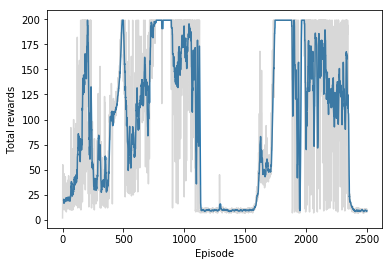

In [37]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

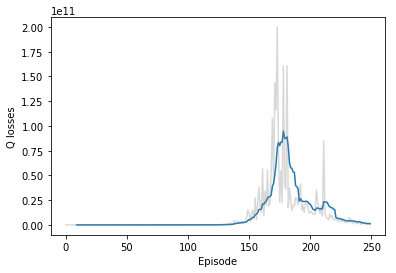

In [24]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

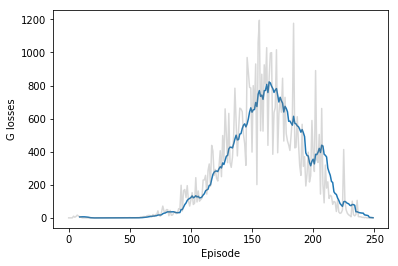

In [25]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

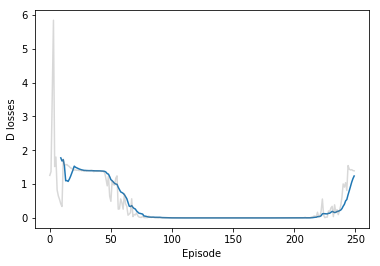

In [26]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [55]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [56]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.